In [ ]:
# turn data from samples to association matrices

In [ ]:
''' inference algorithms '''
# pearson, spearman, kendall, bicor,genie3,pcor,mi,mrnet

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import networkx as nx
from pathlib import Path
from numba import njit

from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
#import sys
#sys.path.append('..') # << depending where genie is
from genie3 import GENIE3

## load raw data

In [6]:
# the MATLAB program returns all evaluated timepoints and in 3 different files.
# this data are the concentration at the final times
raw_data = pd.read_csv('/Users/finn/Desktop/b2_data_reduced.csv',
                       index_col=0)
raw_data

,PC,AA,11_HETE,PGH2,12_HHT,TXA2,TXB2,11dh_TXB2,PGI2,6k_PGE1,...,dhk_PGF2a,d6t_LTB4,d6t_12epi_LTB4,epi12LTB4,d11t_LTC4,d11t_LTD4,d11t_LTE4,8_isoPGF2a_III,5_isoPGF2a_IV,d12_PGJ2
0,0.446145,0.007274,0.000013,0.000061,7.124106e-10,1.445465e-08,1.516219e-09,1.228533e-07,1.639243e-08,1.720035e-09,...,2.939540e-11,5.915842e-07,0.000210,0.000253,4.217033e-12,1.802319e-13,2.068640e-14,0.101445,0.709114,1.202503e-08
1,0.451508,0.006589,0.000018,0.000053,5.998170e-10,1.911138e-08,2.330718e-09,1.032088e-07,1.876298e-08,1.941212e-09,...,2.403777e-11,4.368547e-07,0.000160,0.000149,2.345461e-12,1.133393e-13,9.249909e-15,0.132149,0.242327,1.161714e-08
2,0.464054,0.007049,0.000015,0.000160,1.475881e-09,4.361776e-08,4.083920e-09,1.624094e-07,4.097301e-08,4.095341e-09,...,6.149170e-11,7.591745e-07,0.000218,0.000202,5.012754e-12,2.304218e-13,2.255648e-14,0.113290,0.576920,1.852982e-08
3,0.476022,0.007728,0.000008,0.000133,1.229744e-09,2.523746e-08,2.945910e-09,1.068838e-07,4.058891e-08,3.901726e-09,...,6.791031e-11,5.152998e-07,0.000202,0.000163,3.598704e-12,1.562066e-13,1.450336e-14,0.156153,0.315928,1.563700e-08
4,0.449935,0.007609,0.000014,0.000182,1.891825e-09,4.377805e-08,4.364862e-09,1.863109e-07,6.586009e-08,5.528615e-09,...,8.932383e-11,7.702743e-07,0.000286,0.000215,4.734840e-12,2.836942e-13,3.300356e-14,0.158894,0.601042,2.635969e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.487242,0.008236,0.000013,0.000089,9.128748e-10,1.851893e-08,2.431371e-09,1.347246e-07,2.397133e-08,2.669979e-09,...,4.409424e-11,9.055453e-07,0.000334,0.000274,5.798689e-12,3.555501e-13,4.315231e-14,0.116931,0.485791,1.934440e-08
496,0.464792,0.006990,0.000008,0.000086,8.017247e-10,2.152243e-08,2.595010e-09,1.536597e-07,1.738037e-08,1.901337e-09,...,4.123232e-11,5.648822e-07,0.000205,0.000234,3.327468e-12,1.666596e-13,2.068490e-14,0.168102,0.380788,1.357072e-08
497,0.496995,0.008039,0.000010,0.000225,1.977327e-09,4.407728e-08,4.612782e-09,1.992670e-07,4.381505e-08,4.721780e-09,...,9.799287e-11,6.228181e-07,0.000270,0.000252,5.736621e-12,2.300411e-13,2.321894e-14,0.151208,0.751448,2.252135e-08
498,0.466920,0.008017,0.000009,0.000098,9.903590e-10,3.614264e-08,3.990163e-09,1.413872e-07,2.396524e-08,2.359596e-09,...,4.737302e-11,9.148986e-07,0.000281,0.000298,4.557979e-12,2.241436e-13,2.200893e-14,0.121355,0.316905,1.677233e-08


## matrix functions

In [36]:
def remove_diag(data:np.array) -> np.array:
    return data * ~np.eye(len(data), dtype=bool)
    
def copy_to_upper(data:np.array) -> np.array:
    assert len(data.shape) == 2, 'expecting a 2d array as input'
    temp_data = data + data.T
    # correct the diagonal by multilying it by 0.5
    diag_correction = np.ones_like(data) + np.eye(len(data))*-0.5
    return temp_data * diag_correction

def resample_n_samples(data:np.array, n_samples:int = 100, replacement = False)->np.array:
    if replacement:
        indices = np.random.randint(len(data), size = n_samples)
    else:
        indices = np.random.permutation(500)[:n_samples]
    return data[indices]

## inference methods

In [83]:
# self-contained functions for calculating association matrix

def pearson_wrapper(data:pd.DataFrame) -> np.array:
    # from numpy
    return np.corrcoef(data.T)

def pcor_wrapper(data:pd.DataFrame) -> np.array:
    return np.array(data.pcor())

def _loop_scipy(data, assoc_func):
    n_features = data.shape[1]
    # build out the full array
    temp_assoc = np.zeros((n_features,n_features))
    for i in range(n_features):
        for k in range(i):
            temp_assoc[i,k] = assoc_func(data[:,i],
                                         data[:,k]).statistic
    return temp_assoc
    
def spearman_wrapper(data:pd.DataFrame) -> np.array:
    return _loop_scipy(data, spearmanr)

def kt_wrapper(data:pd.DataFrame) -> np.array:
    return _loop_scipy(data, kendalltau)

def bicor_wrapper(data:pd.DataFrame) -> np.array:
    n_features = data.shape[1]
    # build out the full array
    temp_assoc = np.zeros((n_features,n_features))
    for i in range(n_features):
        for k in range(i):
            temp_assoc[i,k] = _bicor(data[:,i],
                                    data[:,k])
    return temp_assoc
    
@njit
def _bicor(x, y, c=9):

    # Calculate median
    nx = x.size
    x_median = np.median(x)
    y_median = np.median(y)

    # Raw median absolute deviation
    x_mad = np.median(np.abs(x - x_median))
    y_mad = np.median(np.abs(y - y_median))

    # Calculate weights
    u = (x - x_median) / (c * x_mad)
    v = (y - y_median) / (c * y_mad)
    w_x = (1 - u**2) ** 2 * ((1 - np.abs(u)) > 0)
    w_y = (1 - v**2) ** 2 * ((1 - np.abs(v)) > 0)

    # Normalize x and y by weights
    x_norm = (x - x_median) * w_x
    y_norm = (y - y_median) * w_y
    denom = np.sqrt((x_norm**2).sum()) * np.sqrt((y_norm**2).sum())

    # Correlation coefficient
    r = (x_norm * y_norm).sum() / denom
    return r

# run once quickly to get the compilation
_bicor(np.array(raw_data['PC']),
       np.array(raw_data['AA']))

def mi_wrapper(data: pd.DataFrame) -> np.array:
    data = np.array(data)
    n_features = data.shape[1]
    # build out the full array
    temp_assoc = np.zeros((n_features,n_features))
    for i in range(n_features):
        temp_assoc[i,:i+1] = mutual_info_regression(data[:,:i+1],
                                                    data[:,i])
    return temp_assoc


In [97]:
def _calc_mr(data, metabolite_index):
    # creates a set of features that are relevant and not redundant
    # initialization
    mask = np.arange(data.shape[0])
    my_set = list()
    my_set.append(data[metabolite_index].argmax())
    mask[data[metabolite_index].argmax()] = 0

    # loop until overly redundant
    while True:
        best_candidate_idx = ((data[metabolite_index] - data[my_set].mean(axis=0))*mask).argmax()
        best_candidate_val = ((data[metabolite_index] - data[my_set].mean(axis=0))*mask).max()
        if best_candidate_val > 0:
            mask[best_candidate_idx] = 0
            my_set.append(best_candidate_idx)
        else:
            break
    return my_set

def mr_wrapper(data: pd.DataFrame) -> np.array:
    n_features = data.shape[1]
    # start with MI
    mi_array = mi_wrapper(data)
    # do a cleanup
    mi_array = remove_diag(copy_to_upper(mi_array))
    
    # calculate MR mask
    mr_mask = np.zeros((n_features,n_features),dtype=bool)
    for i in range(n_features):
        mrmr_temp = _calc_mr(data = mi_array,
                            metabolite_index = i)
        for k in mrmr_temp:
            mr_mask[i,k] = True

    # apply mask (zero out background interactions)
    mi_array[mr_mask] = 0

    # take maximum (non-symmetrical)
    # (stack original and transposed, flatten by max)
    some_array = np.stack([mi_array, mi_array.T]).max(axis=0)

    return some_array



In [105]:
def genie_wrapper(data:pd.DataFrame) -> np.array:
    data = np.array(data)
    temp_assoc = GENIE3(expr_data = data,
                        ntrees = 1000,
                        nthreads = 8)
    
    # post-proccess (de-directionalize)
    some_array = np.stack([temp_assoc, temp_assoc.T]).max(axis=0)
    
    return some_array

In [98]:
assoc_config = {'sample_sizes':[5,10,20,50,100,200],
                'n_reps':100,
                'n_features':83,
                'save_folder':'/Users/Finn/desktop/assoc_arrays/', # << change to whereever
                'wrappers':{'pearson':pearson_wrapper,
                            'spearman':spearman_wrapper,
                            'kt':kt_wrapper,
                            'bicor':bicor_wrapper,
                            'mi':mi_wrapper,
                            'mr_net':mr_wrapper,
                            'genie3':genie_wrapper,
                           }}

In [56]:
def check_exists(path:str) -> bool:
    return Path(path).exists()

def get_assoc(data:pd.DataFrame,
              assoc_method:str,
              n_samples:int,
              config:dict) -> None:

    path = config['save_folder']+str(assoc_method)+'_'+str(n_samples)+'.npy'
    if check_exists(path):
        print(f'{path} exists; skipping')
        return

    # initialize array to fill
    n_reps = config['n_reps']
    n_features = config['n_features']
    temp_assoc = np.zeros((n_reps, n_features, n_features))

    # fill array
    for _rep in tqdm(range(n_reps)):
        temp_subset = resample_n_samples(data.values,
                                         n_samples = n_samples,
                                         replacement = False)
        # save just the lower triangle, since it keeps the later pipeline easier
        # (the "k=-1" removes the diagonal)
        temp_assoc[_rep] = np.tril(config['wrappers'][assoc_method](temp_subset),
                                   k=-1)
        
    results = np.array(temp_assoc, dtype=np.float32)
    
    print(f'"saved" {path}')
    #np.save(path, results)


In [107]:
# demonstrating usage. trivial to loop through these variables.

get_assoc(data = raw_data,
          assoc_method = 'bicor',
          n_samples = 20,
          config = assoc_config)

  0%|          | 0/100 [00:00<?, ?it/s]

"saved" /Users/Finn/desktop/assoc_arraysbicor_20.npy


## CLR functions

In [109]:
def _bg_normalized(array:np.array,idx0:int,idx1:int):
    x = (array[idx0][idx1] - array[idx0].mean())/array[idx0].std()
    return max(0,x)

def calc_clr(array:np.array, met0:int, met1:int) -> np.array:
    x = _bg_normalized(array, met0, met1)
    y = _bg_normalized(array, met1, met0)
    return np.sqrt(x**2 + y**2)

def apply_clr(assoc_array: np.array) -> np.array:
    ''' used clr to remove background '''
    n_features = len(assoc_array)
    full_clr = np.zeros((n_features,n_features))
    for i in range(n_features):
        for k in range(i+1):
            full_clr[i,k] = calc_clr(array = assoc_array,
                                     met0 = i,
                                     met1 = k)
    return full_clr

In [114]:
# load data, apply this, save elsewhere

def get_clr_assoc(load_file_path:str,
                  n_samples:int,
                  config:dict = assoc_config) -> None:

    # don't overwrite
    path = config['save_folder']+'clr_'+str(n_samples)+'.npy'
    if check_exists(path):
        print(f'{path} exists; skipping')
        return

    # load file
    temp_assoc = np.load(load_file_path)
    print(temp_assoc.shape)

    # initialize array
    results = np.zeros_like(temp_assoc)
    # apply clr 
    for i,_data in enumerate(temp_assoc):
        _data = copy_to_upper(_data)
        results[i] = apply_clr(_data)
    
    results = results.astype(np.float32)
    
    print(f'"saved" {path}')
    #np.save(path, results)

get_clr_assoc('/Users/finn/desktop/assoc/b_20.npy', n_samples = 20)

(100, 83, 83)
"saved" /Users/Finn/desktop/assoc_arraysclr_20.npy


## PCLRC
Ran as script due to significant running time (pooling doesn't work within a notebook)<br>
This creates all the association matrices, and the clr and p parts are applied afterwards.

In [ ]:

import numpy as np
from multiprocessing import Pool
import pandas as pd
from pathlib import Path
from functools import partial

def resample_n_samples(data:np.array, n_samples:int = 100, replacement = False)->np.array:
    if replacement: indices = np.random.randint(len(data), size = n_samples)
    else: indices = np.random.permutation(500)[:n_samples]
    return data[indices]

def load_data(path):
    # load data in df
    return pd.read_csv(path, index_col=0)
    
data = load_data('some_path_to_data.csv')

''' ----------------------------------- '''

n_reps = 100
pclrc_samples = 1000
reps_per_thread = 4 # should be divisible by 100 for simplicity

temp_data = data.values
col_names = data.columns
n_features = len(col_names)

def solo_pclrc_run(iteration, n_samples, seed, assoc_method):
    # ensure variation
    np.random.seed(seed) # consistency in selection of original samples
    
    # take samples
    temp = resample_n_samples(temp_data,
                              n_samples = n_samples) # get N samples

    np.random.seed(iteration) # variation in selecting subset

    temp_assoc = np.zeros((reps_per_thread, n_features, n_features))
    for _rep_thing in range(reps_per_thread):
        # get random resampling (with replacement)
        temp_subset = resample_n_samples(temp,
                                         n_samples = int(n_samples * 0.75),
                                         replacement = True) # randomly resample 
        
        # build out the full array
        for i in range(n_features):
            for k in range(i):
                temp_assoc[_rep_thing,i,k] = bicor(temp_subset[:,i],
                                                   temp_subset[:,k])
        
    return temp_assoc


if __name__ == '__main__':

    for _n_sample in [5,10,20,50,100,200]:
        
        for i in range(n_reps):
            path = f'/Users/finn/desktop/assoc/pclrc_b{_n_sample}/{str(i).zfill(3)}.npy'
            if Path(path).exists():
                continue
            else:
                #print(np.arange(int(pclrc_samples/reps_per_thread)))
                with Pool() as p:
                    results = p.map(partial(solo_pclrc_run, n_samples = _n_sample, seed = i),
                                    np.arange(int(pclrc_samples/reps_per_thread))) # 2 arrays per
                results = np.array(results, dtype=np.float32)
                np.save(path, results)


## pclrc wrapper

In [ ]:
def pclrc_the_folder(folder_path, save_path, config:dict = assoc_config):
    # TODO: folder path should be a list instead
    
    # compile the pclrc resamplings into a single finished 
    pclrc_folders = glob.glob(f'{folder_path}*')
    source_len = len(folder_path.split('_')[1])
    
    for _folder in pclrc_folders:
        
        _n_samples = extract_numerics(_folder.split('_')[1])
        _source = _folder.split('_')[1][:source_len]
        _save_path = f'{save_path}final_{_source}_{_n_samples}.npy'
        
        if Path(_save_path).exists():
            print(f'skipping {_n_samples} (already run)')
            continue
        else:
            z = np.zeros((config['n_features'],config['n_features'],config['n_reps']))
            for i in tqdm(range(config['n_reps'])):
                # load data
                temp_data = np.load(f'{_folder}/{str(i).zfill(3)}.npy')
                # some data was prepared in batches
                temp_data = temp_data.reshape(-1,config['n_features'],config['n_features'])
                temp_data = copy_to_upper(temp_data)

                # apply some filters to prevent disaster
                _quick_process = temp_data.var(axis=1).min(axis=1)
                nan_mask = np.isfinite(_quick_process) # identifies nans
                var_mask = (_quick_process != 0) # removes zero variance samples

                # apply both masks
                temp_data_masked = temp_data[nan_mask*var_mask]
                
                z[:,:,i] = process_pclrc(data = temp_data_masked)
            
            print(f'finished {_n_samples}')
            np.save(_save_path, z)

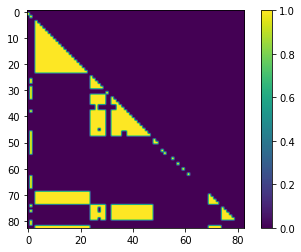

In [148]:
''' merge PCLRC down '''
def consolidate(pclr_array, percentile:float = 30.0, binarize_treshold:float = 0.95):
    
    binarizable = np.zeros((83,83))
    for _iteration in pclr_array:
        temp_lower = np.tril(_iteration)
        perc_mask = (temp_lower != 0)
        perc_value = np.percentile(temp_lower[perc_mask], q=percentile)

        new_perc_mask = np.where(temp_lower > perc_value, 1, 0)
        binarizable += new_perc_mask
    
    # merge them down
    binarizable = binarizable/len(pclr_array)
    temp_mask = (binarizable > binarize_treshold)
    
    return temp_mask

spearman_attempt = consolidate(pclr_array = pclr_test)
plt.imshow(spearman_attempt)
plt.colorbar()
